In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

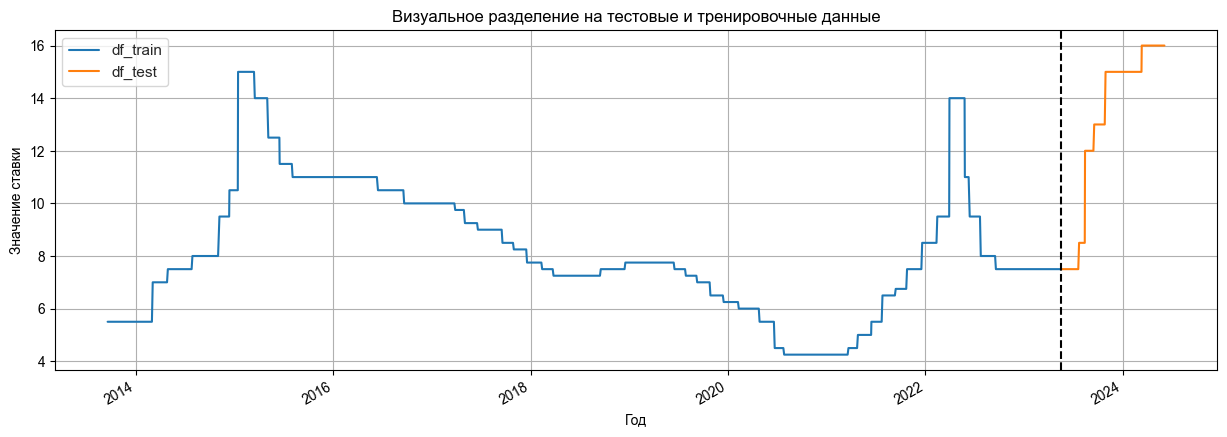

In [75]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [4]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:12:39 - cmdstanpy - INFO - Chain [1] start processing
02:12:40 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [6]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2666,2024-02-04,10.814738,9.221886,12.483391
2667,2024-02-05,10.272174,8.708364,11.845128
2668,2024-02-06,10.280907,8.810098,11.996628
2669,2024-02-07,10.298326,8.755077,12.009441
2670,2024-02-08,10.302670,8.632807,11.894315


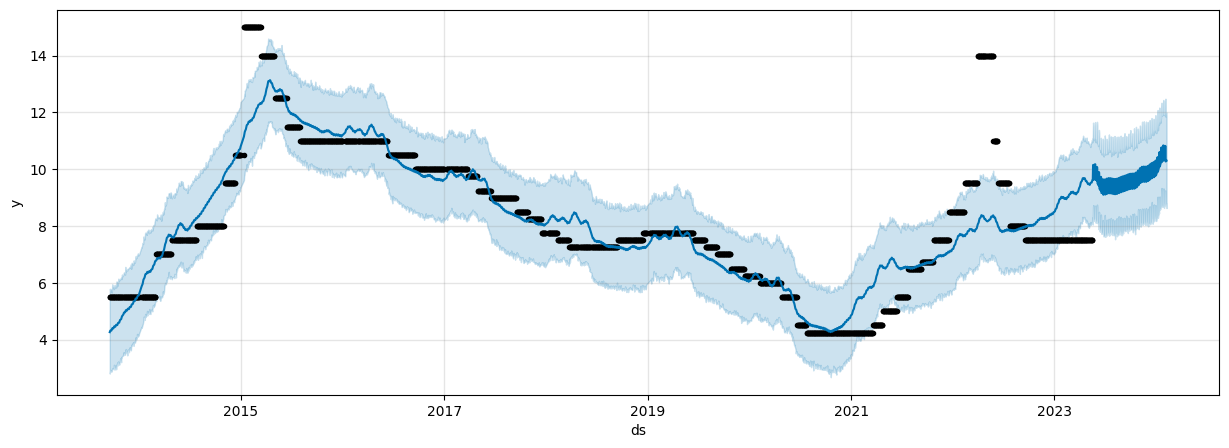

In [7]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

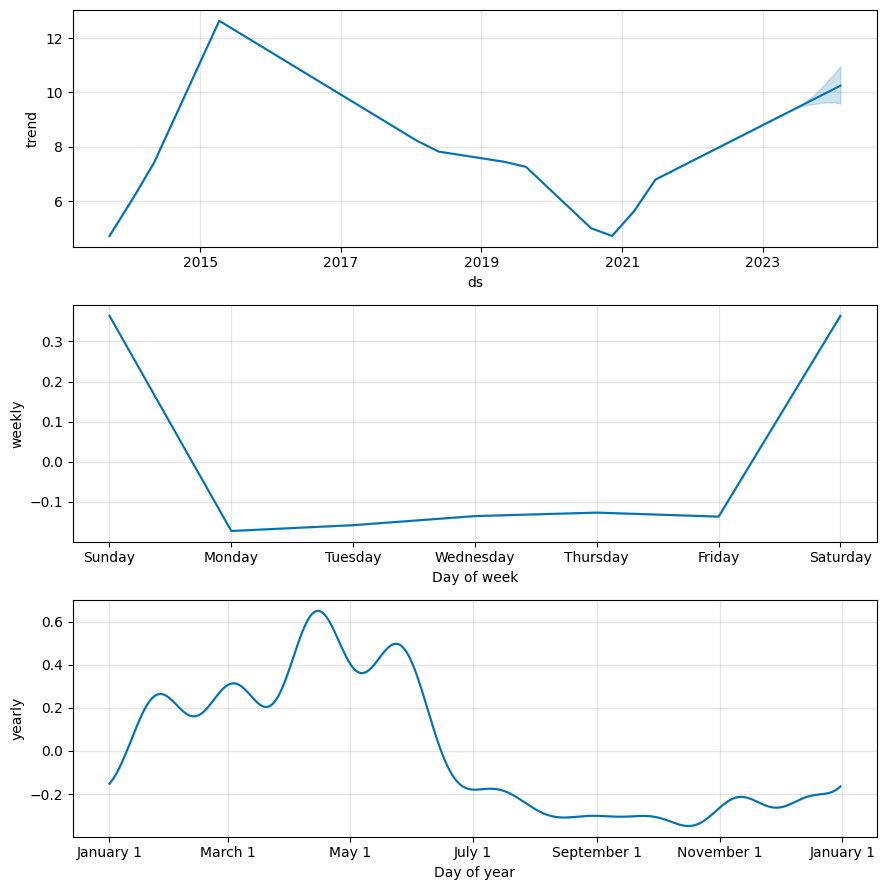

In [8]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [9]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-05-29,10.967114,9.108750,12.862736
263,2024-05-30,10.962522,9.056320,12.831832
264,2024-05-31,10.936704,9.001982,12.744411
265,2024-06-03,10.840151,8.810720,12.784476
266,2024-06-04,10.830855,8.762635,12.730994


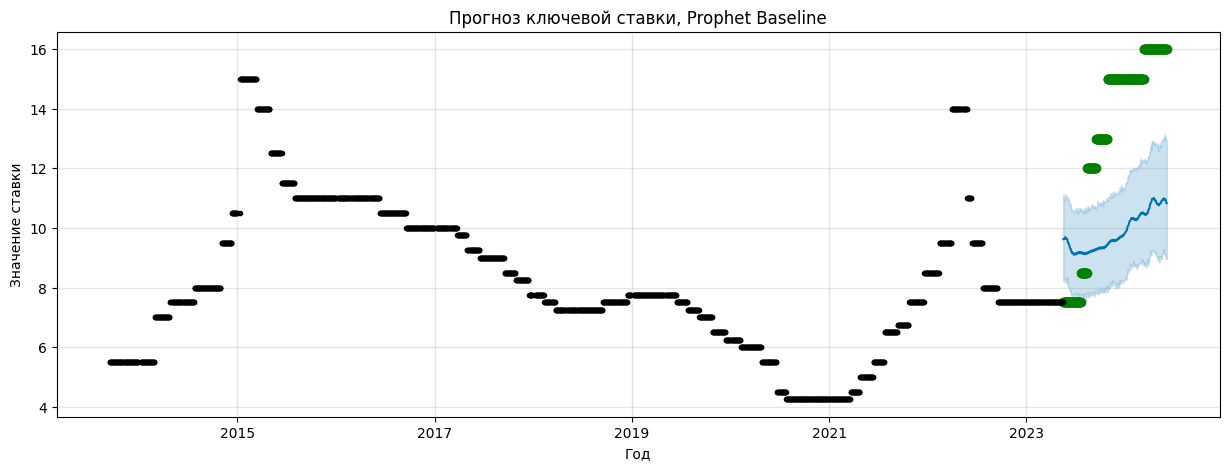

In [10]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

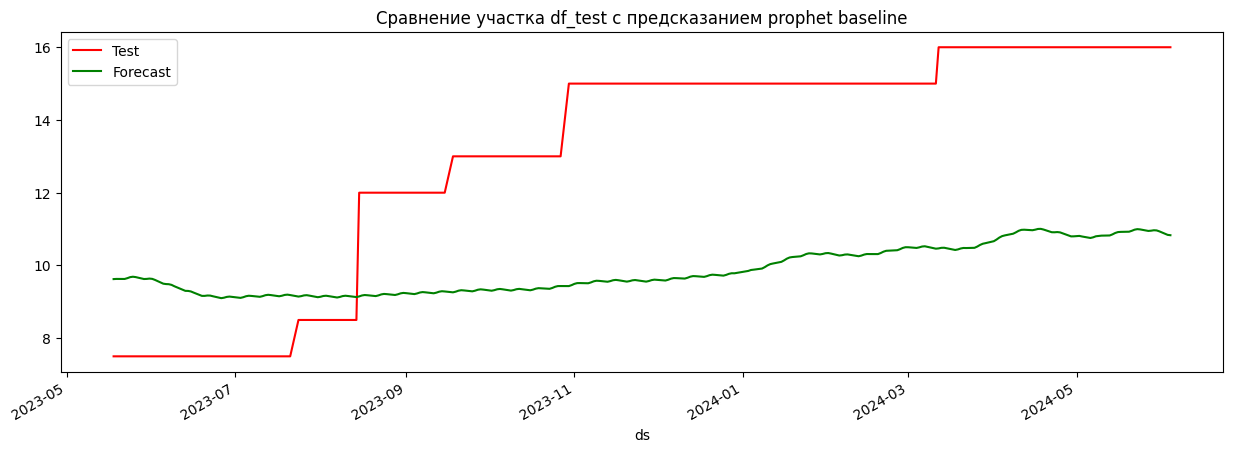

In [11]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [12]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.904485,0.286877,17.625173,4.198235


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [13]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [14]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:12:43 - cmdstanpy - INFO - Chain [1] start processing
02:12:44 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2666,2024-02-04,10.854419,9.296958,12.666764
2667,2024-02-05,10.280183,8.711966,11.874567
2668,2024-02-06,10.289147,8.700909,11.974259
2669,2024-02-07,10.308332,8.607076,11.969772
2670,2024-02-08,10.312270,8.695061,11.969564


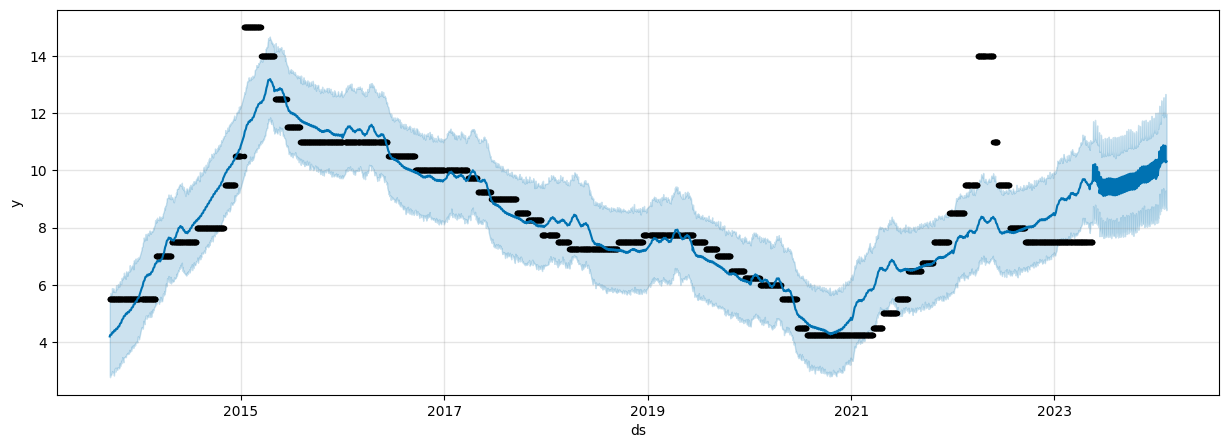

In [16]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

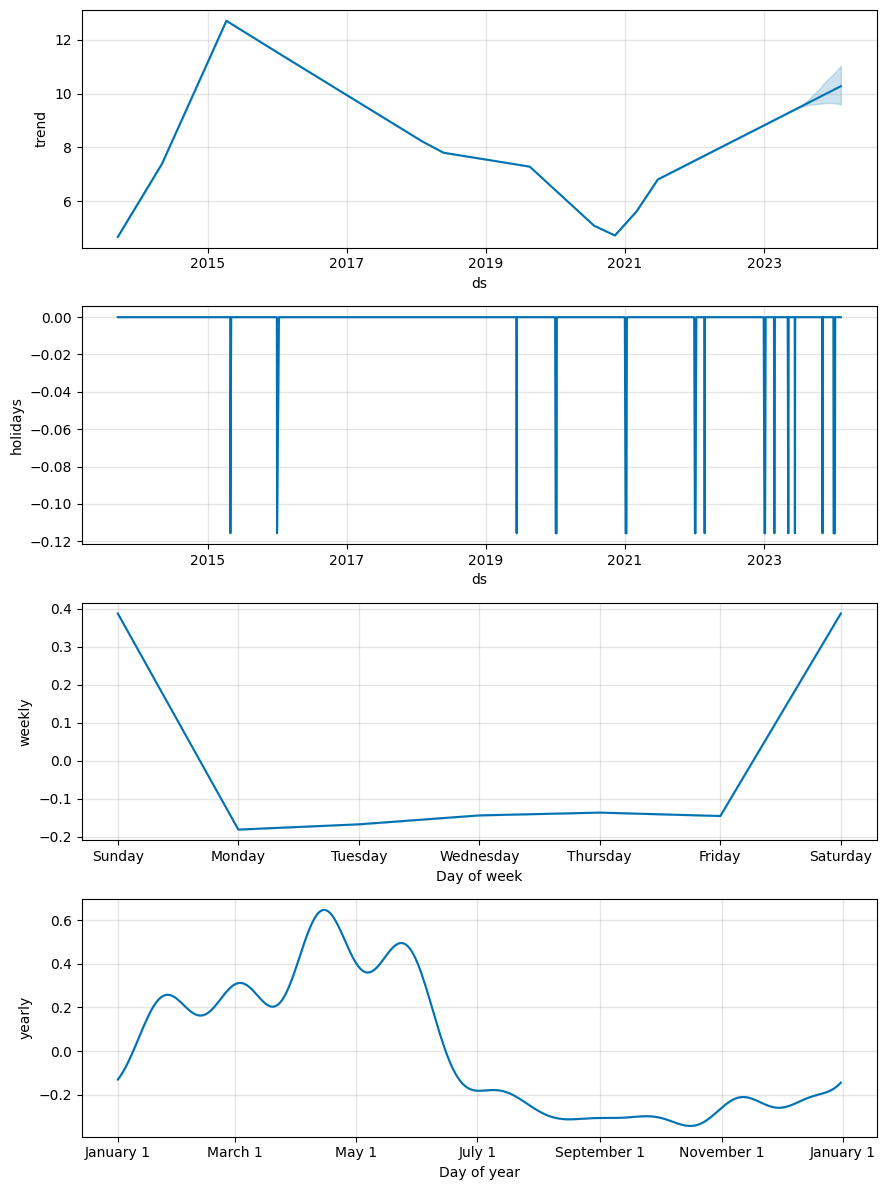

In [17]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [18]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-05-29,10.980863,9.010191,12.860955
263,2024-05-30,10.974976,9.091122,12.903074
264,2024-05-31,10.950198,9.023497,12.905943
265,2024-06-03,10.853578,8.914286,12.958640
266,2024-06-04,10.843545,8.827976,12.674010


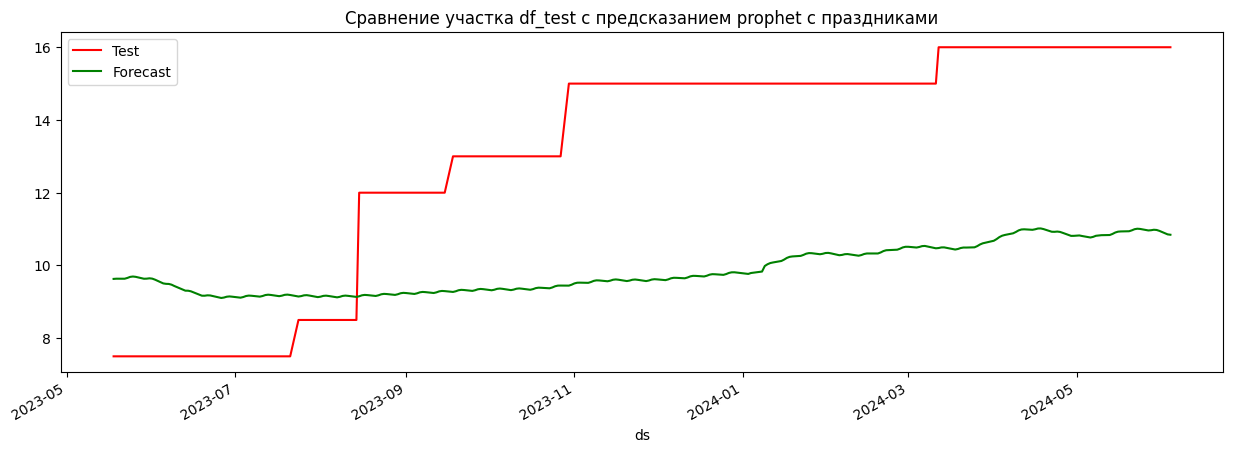

In [19]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [20]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.904485,0.286877,17.625173,4.198235
0,Prophet_with_holidays,3.897753,0.286486,17.555361,4.189912


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [21]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [22]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]02:12:46 - cmdstanpy - INFO - Chain [1] start processing
02:12:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<07:11,  1.55it/s]02:12:47 - cmdstanpy - INFO - Chain [1] start processing
02:12:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<07:06,  1.57it/s]02:12:48 - cmdstanpy - INFO - Chain [1] start processing
02:12:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:01<07:29,  1.49it/s]02:12:49 - cmdstanpy - INFO - Chain [1] start processing
02:12:49 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:02<07:56,  1.40it/s]02:12:49 - cmdstanpy - INFO - Chain [1] start processing
02:12:49 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:03<07:26,  1.49it/s]02:12:50 - cmdstanpy - INFO - Chain [1] start processing
02:12:50 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:03<07:14,  1.53it/s]0

In [23]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [24]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,6.487475,0.451678,53.064185,7.284517,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,6.836203,0.478346,58.381303,7.640766,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,6.731465,0.469826,56.914862,7.544194,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,6.941664,0.486573,59.978498,7.744579,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,6.462851,0.448749,53.096856,7.286759,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.018965,0.923973,259.660061,16.113971,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.888953,0.344482,29.802348,5.459153,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.922361,0.346768,30.194367,5.494940,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.959697,0.348784,30.738362,5.544219,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [25]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.906897,0.294183,17.234652,4.151464,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
1,Prophet_with_grid,3.906897,0.294183,17.234652,4.151464,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
2,Prophet_with_grid,3.906897,0.294183,17.234652,4.151464,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
3,Prophet_with_grid,3.906897,0.294183,17.234652,4.151464,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
4,Prophet_with_grid,3.916335,0.294787,17.343098,4.164505,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [26]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.03,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 1}

In [27]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:30:05 - cmdstanpy - INFO - Chain [1] start processing
02:30:06 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2666,2024-02-04,11.459743,9.835096,13.076499
2667,2024-02-05,10.846615,9.115831,12.477893
2668,2024-02-06,10.857544,9.162096,12.381399
2669,2024-02-07,10.879057,9.254698,12.404094
2670,2024-02-08,10.881525,9.335446,12.506251


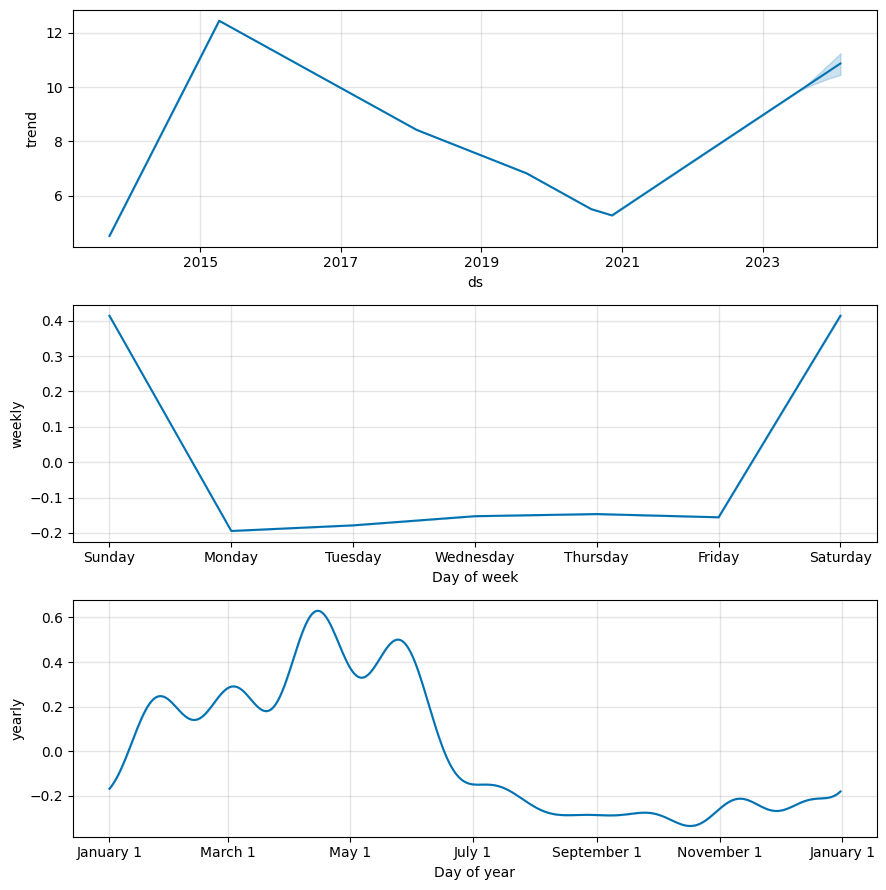

In [29]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

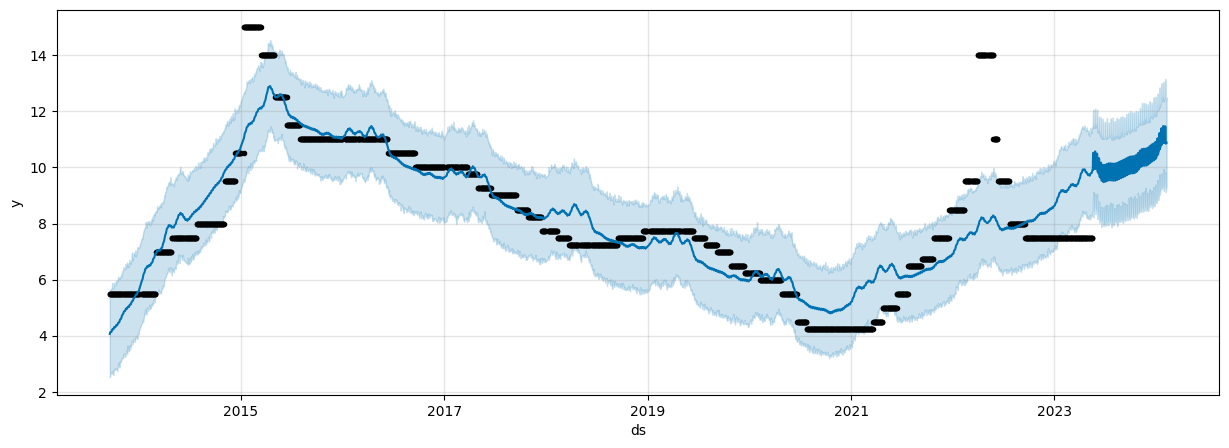

In [30]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [31]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
262,2024-05-29,11.708101,9.869204,13.238402
263,2024-05-30,11.704216,9.983822,13.438358
264,2024-05-31,11.682583,9.991448,13.272767
265,2024-06-03,11.592124,9.794396,13.240030
266,2024-06-04,11.586820,9.949338,13.237569


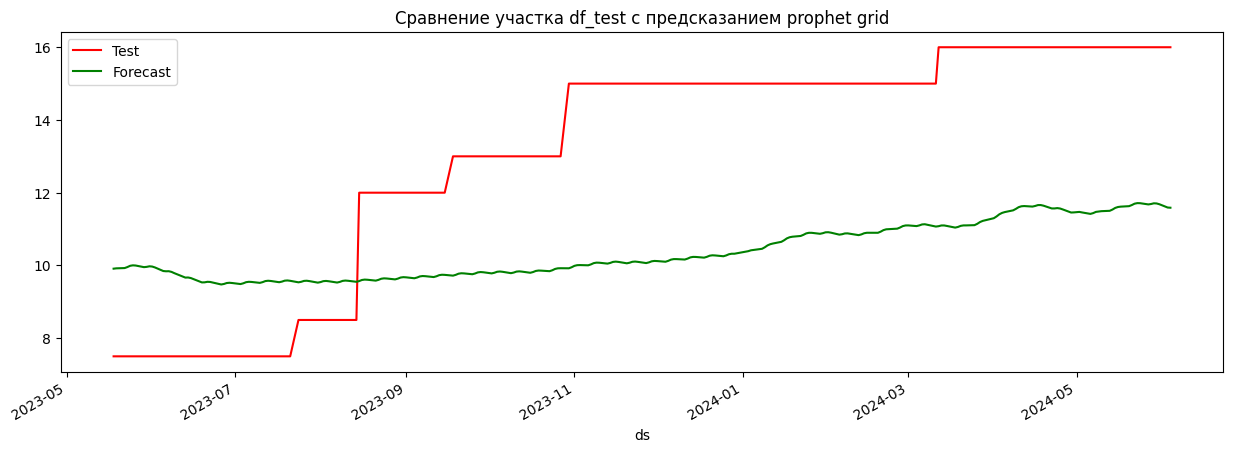

In [32]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [33]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.904485,0.286877,17.625173,4.198235
0,Prophet_with_holidays,3.897753,0.286486,17.555361,4.189912
0,Prophet_with_grid,3.563537,0.268945,14.133808,3.759496


In [34]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [55]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [56]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.378% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.378% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
262,2024-05-29,16.0,11.499132,9.899673,0.345444,1.254015
263,2024-05-30,16.0,11.509043,9.904588,0.348801,1.255654
264,2024-05-31,16.0,11.511892,9.909506,0.351324,1.251063
265,2024-06-03,16.0,11.504900,9.924252,0.353719,1.226930
266,2024-06-04,16.0,11.514530,9.929167,0.352746,1.232617


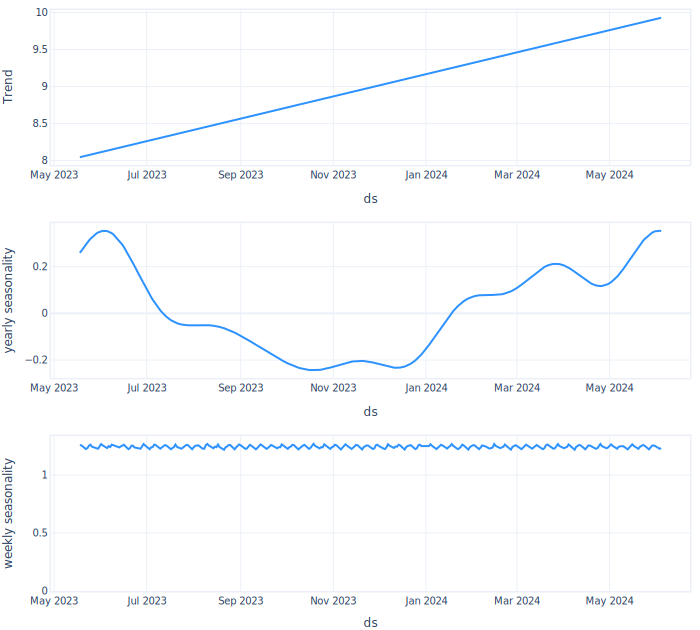

In [57]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

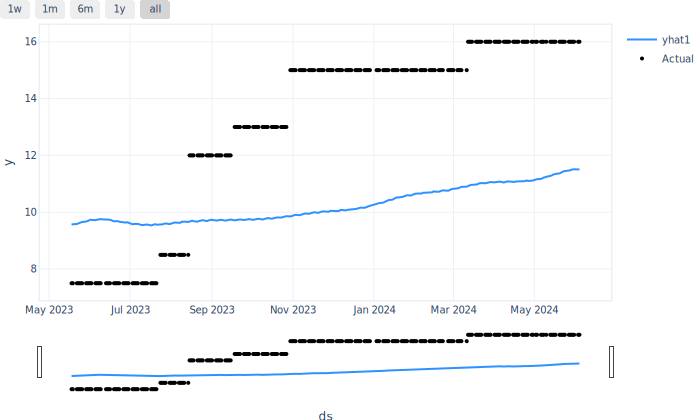

In [58]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

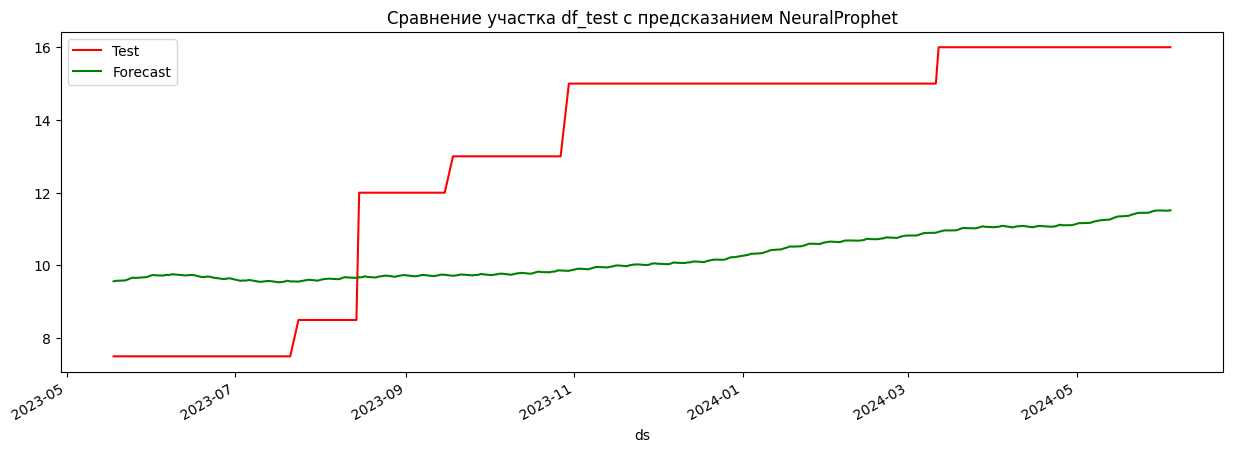

In [59]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [60]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.904485,0.286877,17.625173,4.198235
0,Prophet_with_holidays,3.897753,0.286486,17.555361,4.189912
0,Prophet_with_grid,3.563537,0.268945,14.133808,3.759496
0,NeuralProphet,3.670573,0.275621,15.111314,3.887327
0,NeuralProphet,3.678147,0.275928,15.195755,3.898173


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на df

# Prophet baseline on df

In [61]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

02:44:25 - cmdstanpy - INFO - Chain [1] start processing
02:44:26 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2846,2024-11-27,15.326858,13.524066,17.070126
2847,2024-11-28,15.333808,13.469452,17.043788
2848,2024-11-29,15.328256,13.476756,17.075765
2849,2024-11-30,16.130839,14.349058,17.905468
2850,2024-12-01,16.139985,14.289964,17.910937


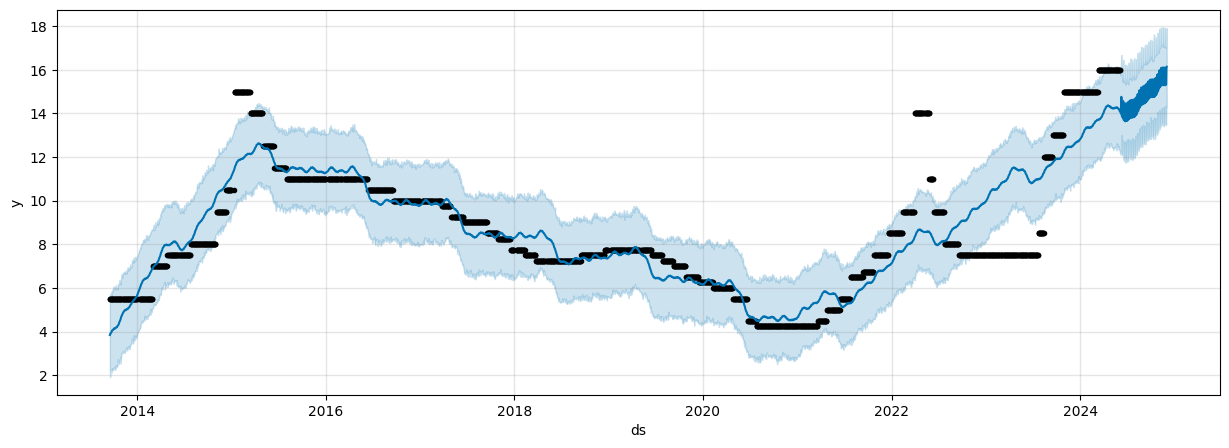

In [63]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

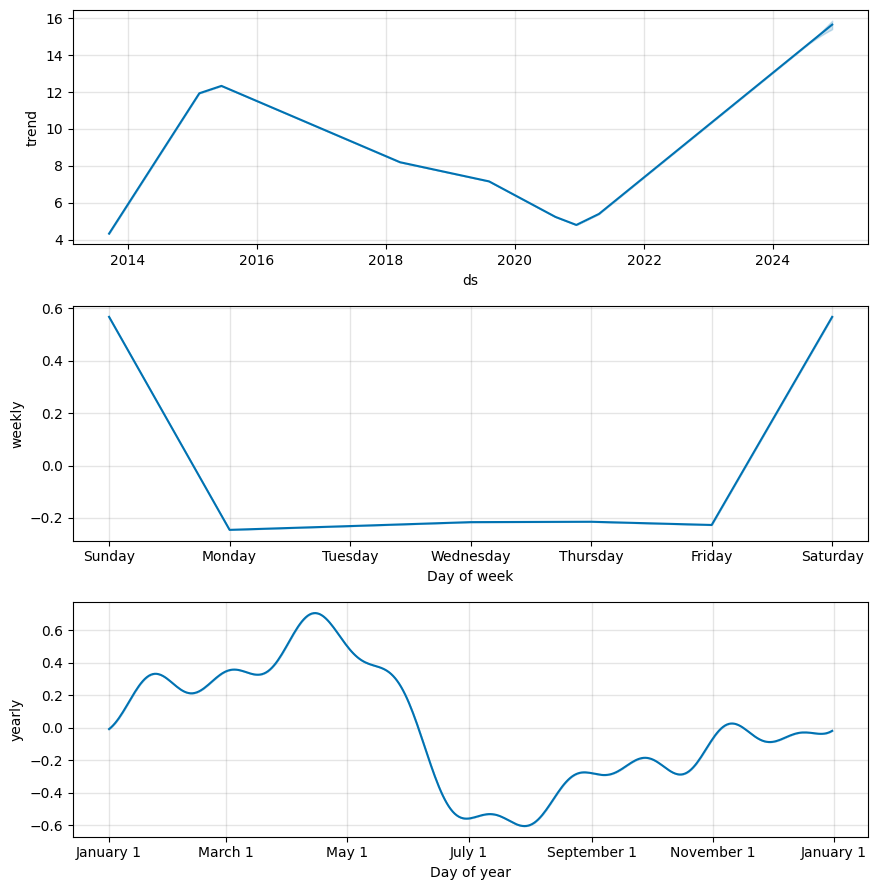

In [64]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [65]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

02:44:28 - cmdstanpy - INFO - Chain [1] start processing
02:44:29 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2846,2024-11-27,15.326858,13.512779,17.230375
2847,2024-11-28,15.333808,13.545938,17.054179
2848,2024-11-29,15.328256,13.539680,17.189951
2849,2024-11-30,16.130839,14.310089,17.968983
2850,2024-12-01,16.139985,14.345160,17.997619


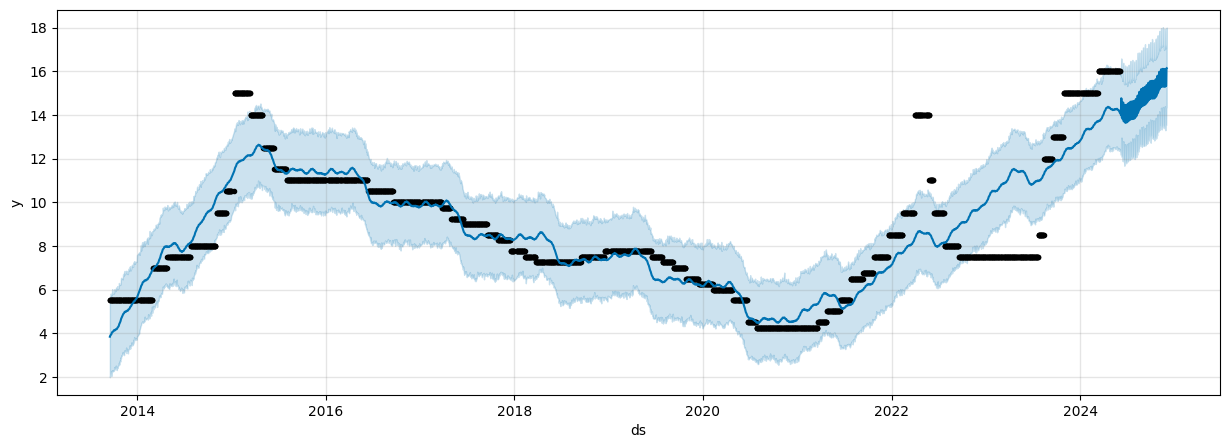

In [67]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

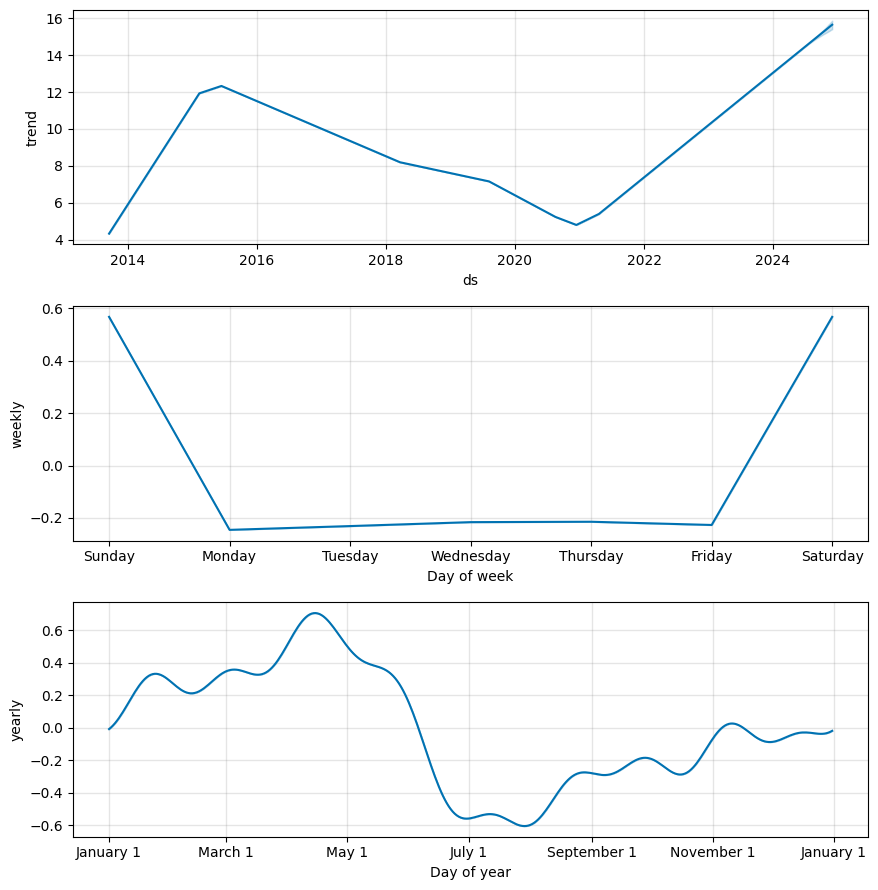

In [68]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [69]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.192% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (42) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [70]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.192% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.27% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.27% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 76 rows at the end with NaNs in 'y' column.


Predicting: 42it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2742,2024-09-12,NaN,14.917965,13.426897,-0.104907,1.595975
2743,2024-09-13,NaN,14.919748,13.435062,-0.108471,1.593157
2744,2024-09-16,NaN,14.927214,13.459558,-0.122292,1.589949
2745,2024-09-17,NaN,14.923575,13.467726,-0.127766,1.583615
2746,2024-09-18,NaN,14.943013,13.475891,-0.133559,1.600682


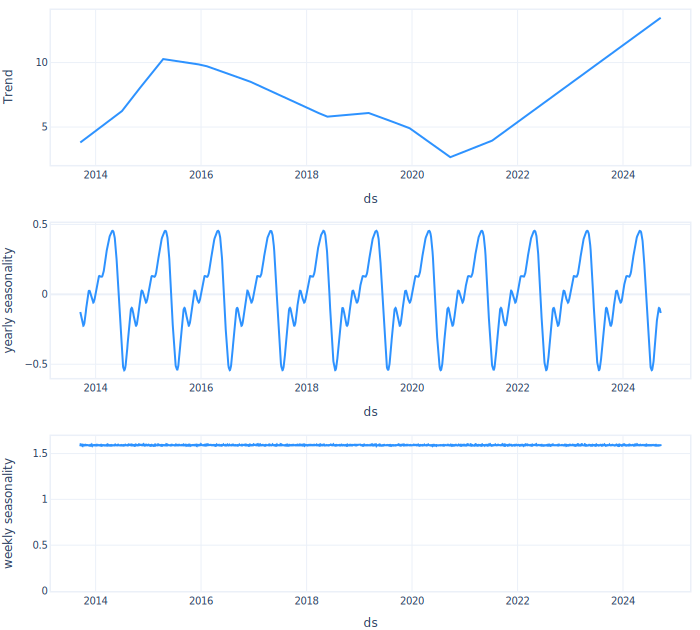

In [71]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

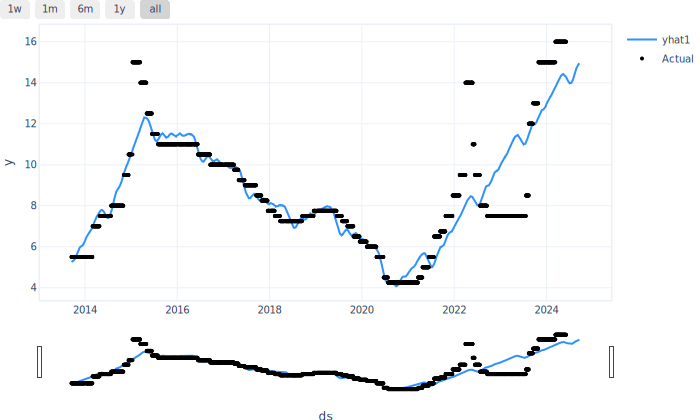

In [72]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей

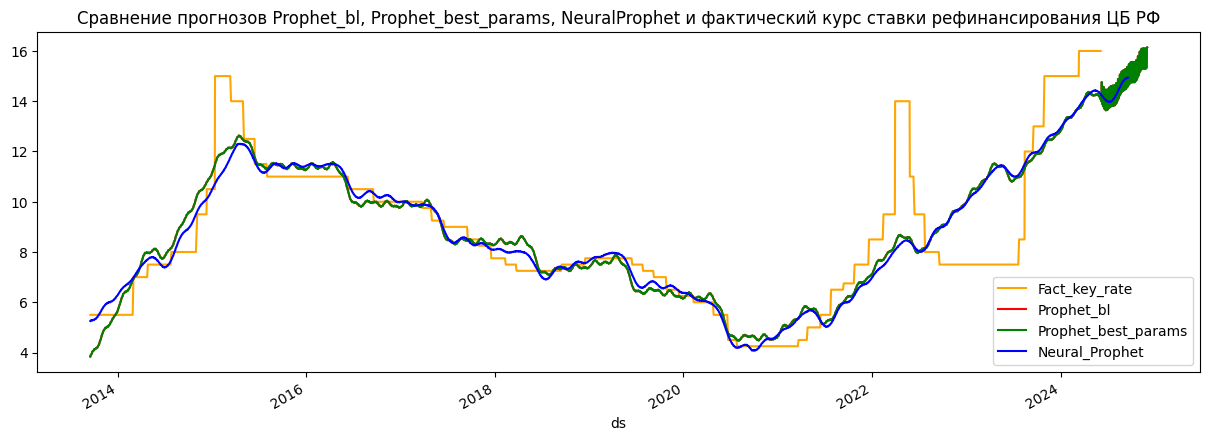

In [73]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.